# hub más grande agarrando el grafo 3D del examen del ejercicio 5 chb01_01.edf, y comunidades dibujar con diferentes colores 

5. Utilizando el dataset de _chb01_01.edf_:
- Genere el grafo 3D
- Haga que el tamaño de nodos sea proporcional a su grado; es decir, q entre mayor sea su grado, mayor sea el tamaño del nodo ploteado
- Haga que el color de las aristas este relacionado al valor de la matriz de conectividad. Utilizar el map color Hot

In [26]:
import numpy as np
import pandas as pd
import mne
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from networkx.algorithms import community

raw = mne.io.read_raw_edf(
    r"C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\chb01_01.edf",
    preload=True,
    verbose=False
)

data = raw.get_data()
ch_names = raw.ch_names
n_channels = len(ch_names)

corr_matrix = np.corrcoef(data)
np.fill_diagonal(corr_matrix, 0) 


C:\Users\Ana-Sophia Redstone\AppData\Local\Temp\ipykernel_20600\1208462714.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(


In [27]:
G_edf = nx.Graph()
for i in range(n_channels):
    for j in range(i+1, n_channels):
        weight = corr_matrix[i, j]
        if abs(weight) > 0.5: 
            G_edf.add_edge(ch_names[i], ch_names[j], weight=weight)


In [28]:
coords_df = pd.read_csv(
    r"C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\coordenadas_bipolares_eeg.csv"
)

coords_df.columns = coords_df.columns.str.strip()

name_col = [c for c in coords_df.columns if c.lower() not in ['x', 'y', 'z']][0]

coords_dict = {
    row[name_col]: np.array([row['x'], row['y'], row['z']])
    for _, row in coords_df.iterrows()
    if row[name_col] in G_edf.nodes()
}

In [29]:
pos_dict = {node: coords_dict[node] for node in G_edf.nodes() if node in coords_dict}

In [30]:
degrees = dict(G_edf.degree())
node_sizes = [degrees[node]*80 for node in G_edf.nodes()]

edge_weights = np.array([G_edf[u][v]['weight'] for u,v in G_edf.edges()])
norm = (np.abs(edge_weights) - np.min(np.abs(edge_weights))) / (np.max(np.abs(edge_weights)) - np.min(np.abs(edge_weights)))
edge_colors = cm.hot(norm)

In [31]:
communities_list = list(community.greedy_modularity_communities(G_edf))
community_colors = plt.cm.tab10(np.linspace(0, 1, len(communities_list)))

node_colors = []
for node in G_edf.nodes():
    for i, comm in enumerate(communities_list):
        if node in comm:
            node_colors.append(community_colors[i])

In [32]:
hub_node = max(degrees, key=degrees.get)

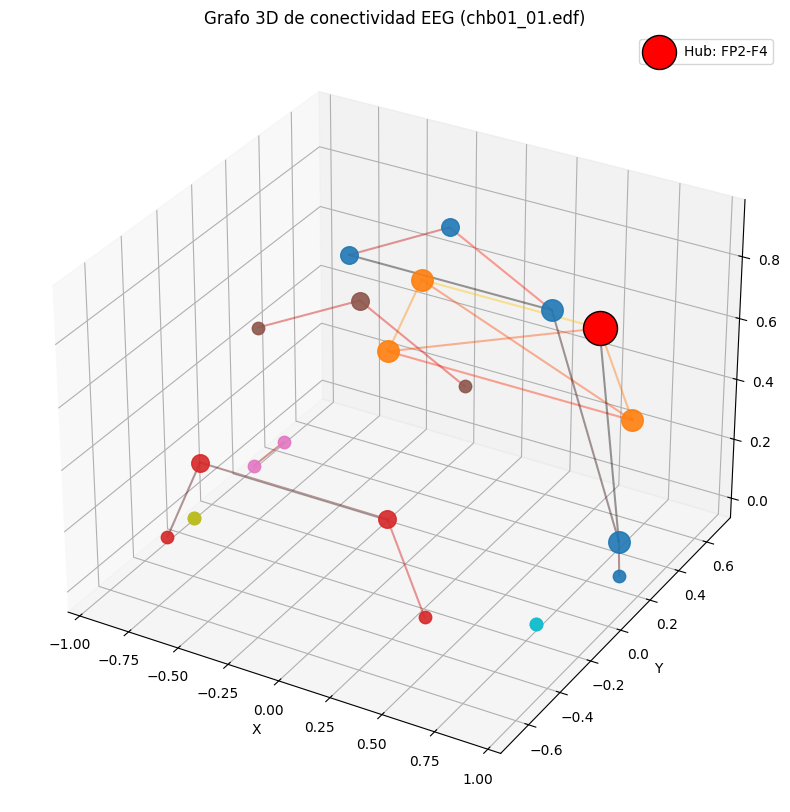

In [34]:
# HUB principal
hub_node = max(degrees, key=degrees.get)

# GRAFO 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# NODOS
for i, node in enumerate(G_edf.nodes()):
    if node in pos_dict:
        x, y, z = pos_dict[node]
        ax.scatter(x, y, z, s=node_sizes[i], color=node_colors[i], alpha=0.9)

# ARISTAS
for i, (u, v) in enumerate(G_edf.edges()):
    if u in pos_dict and v in pos_dict:
        x = [pos_dict[u][0], pos_dict[v][0]]
        y = [pos_dict[u][1], pos_dict[v][1]]
        z = [pos_dict[u][2], pos_dict[v][2]]
        ax.plot(x, y, z, color=edge_colors[i], alpha=0.4)

# HUB MÁS GRANDE 
if hub_node in pos_dict:
    x, y, z = pos_dict[hub_node]
    ax.scatter(
        x,
        y,
        z,
        s=degrees[hub_node] * 150,
        color="red",
        edgecolors="black",
        label=f"Hub: {hub_node}",
        zorder=10
    )

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Grafo 3D de conectividad EEG (chb01_01.edf)")
plt.legend()
plt.show()